In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
df = pd.read_csv('well_1_clean.csv')
series = pd.Series(data = df['Oil Volume'])

In [6]:
#make stationary
log_series = series.apply(lambda x: np.log(x))

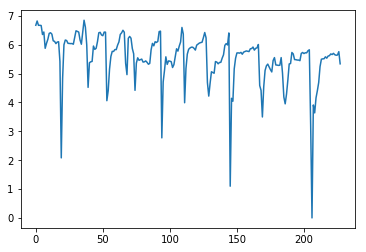

In [7]:
plt.plot(log_series)

In [37]:
roll_factor = 5
moving_avg = log_series.rolling(roll_factor).mean()

In [38]:
diff_log_series = log_series - moving_avg
diff_log_series.dropna(inplace = True)

In [39]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(roll_factor).mean()
    rolstd = timeseries.rolling(roll_factor).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

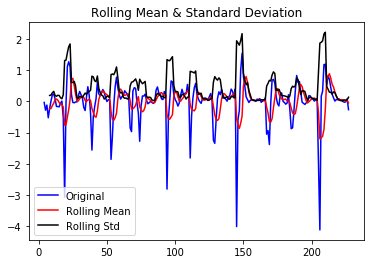

Results of Dickey-Fuller Test:
Test Statistic                -9.566860e+00
p-value                        2.344487e-16
#Lags Used                     3.000000e+00
Number of Observations Used    2.200000e+02
Critical Value (1%)           -3.460428e+00
Critical Value (5%)           -2.874769e+00
Critical Value (10%)          -2.573821e+00
dtype: float64


In [40]:
test_stationarity(diff_log_series)

In [41]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(diff_log_series, nlags=30)
lag_pacf = pacf(diff_log_series, nlags=10, method='ols')

Text(0.5,1,'Autocorrelation Function')

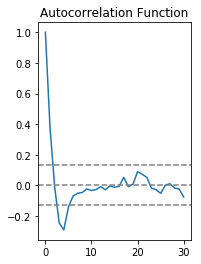

In [42]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff_log_series)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff_log_series)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#set value of q to 1

Text(0.5,1,'Partial Autocorrelation Function')

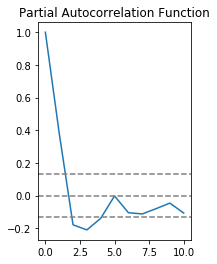

In [43]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff_log_series)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff_log_series)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
#set value of p to 1

Test RMSE: 0.600


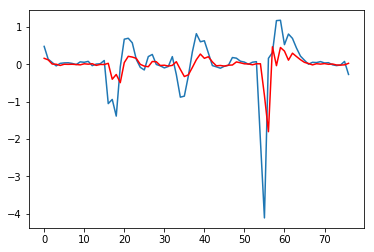

In [44]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
X = diff_log_series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(1,0,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
error = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')

In [45]:
moving_avg = log_series.rolling(roll_factor).mean()
predictions = np.array(predictions).reshape(len(predictions))
moving_avg.dropna(inplace = True)
moving_avg.reset_index(inplace = True, drop = True)
moving_avg = np.array(moving_avg)

In [46]:
scaled_predictions = predictions + moving_avg[len(train):]
final_predictions = np.exp(scaled_predictions)

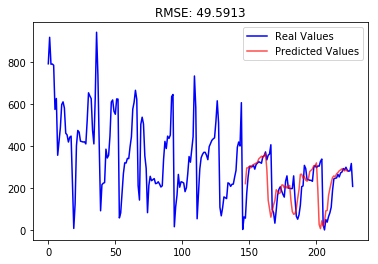

In [47]:
plt.plot(series, c = 'b')
plt.plot([None for x in train] + [x for x in final_predictions], c = 'r', alpha = .7)
plt.title('RMSE: %.4f'% np.sqrt(mean_squared_error(series[-len(final_predictions):], final_predictions)))
plt.legend(['Real Values', 'Predicted Values'])